In [ ]:
# -*- coding: utf-8 -*-
"""
K=7 专用版本
- 只绘制 K=7 的图
- 确保政策和国家的每个子聚类行列间距完全一致
- 政策：每列最多6个，统一行间距
- 国家：每列最多9个，统一行间距
- 政策排序：优先级最高是共有政策，其次是跨多个聚类的政策，最后是单聚类政策
"""

import os, math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from collections import Counter

# ======= 配置区 =======
PATH_CONSENSUS = r'F:\Desktop\CAMPF_Supplementary\data\4-3-Policy_Consensus_Map\Consensus_threshold_greater_than_80\4-3-Filtered_High_Consensus_Policies.csv'
PATH_MAPPING   = r'F:\Desktop\CAMPF_Supplementary\data\4-2-Consensus_Policy_Cluster_Mapping.csv'

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Noto Sans CJK SC', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 类别颜色
CAT_COLOR = {'部门政策': '#D94C4C', '跨部门政策': '#2CA6A4', '国际政策': '#E6B422'}

# —— 布局控制（政策）——
POLICY_FILL_MODE     = 'by_col'
POLICY_COLS_FIXED    = None       # 不固定列数
POLICY_ITEMS_PER_COL = 6          # 每列最多6个
POLICY_ITEMS_PER_ROW = None

# —— 布局控制（国家）——
COUNTRY_FILL_MODE    = 'by_col'
COUNTRY_COLS_FIXED   = None       # 不固定列数
COUNTRY_ITEMS_PER_COL= 9          # 每列最多9个
COUNTRY_ITEMS_PER_ROW= None

# —— 列间距 ——
POLICY_COL_GAP  = 0.025   # 统一
COUNTRY_COL_GAP = 0.025   # 统一

# —— 行间距统一设置 ——
POLICY_ITEM_HEIGHT = 0.12    # 每条政策的固定高度（相对于父容器）
COUNTRY_ITEM_HEIGHT = 0.085  # 每条国家的固定高度（相对于父容器）

# ======= 工具函数 =======
def wrap_cn(text: str, max_chars: int, max_lines: int = 2):
    """粗略按字符折行"""
    if text is None:
        return ['']
    s = str(text).strip().replace('\r', ' ').replace('\n', ' ')
    lines, i = [], 0
    while i < len(s):
        lines.append(s[i:i+max_chars])
        i += max_chars
        if len(lines) >= max_lines:
            if i < len(s):
                lines[-1] = lines[-1].rstrip() + '…'
            break
    return lines or ['']

def ellipsis(text: str, max_chars: int):
    if text is None: return ''
    s = str(text).strip()
    return s if len(s) <= max_chars else (s[:max_chars-1] + '…')

def choose_grid(n_items: int):
    """整张图的网格"""
    if n_items <= 4:   ncols = 2
    elif n_items <= 9: ncols = 3
    elif n_items <= 16:ncols = 4
    elif n_items <= 25:ncols = 5
    else:              ncols = 6
    nrows = math.ceil(n_items / ncols)
    return nrows, ncols

def plan_rows_cols(n_items, fill_mode, cols_fixed=None, items_per_col=None, items_per_row=None,
                   max_cols=4, card_height_factor=0.7):
    """
    计算 rows, cols 和映射方式
    返回：rows, cols, index_to_row_col(i)->(row, col)
    """
    n_items = int(n_items)
    if n_items <= 0:
        return 1, 1, lambda i: (0, 0)

    # 1) 固定：每行条数（= 固定列数）
    if items_per_row is not None and items_per_row > 0:
        cols = max(1, int(items_per_row))
        cols = min(cols, max_cols)
        rows = math.ceil(n_items / cols)

    # 2) 固定：每列最多条数
    elif items_per_col is not None and items_per_col > 0:
        rows = max(1, int(items_per_col))
        cols = math.ceil(n_items / rows)
        cols = min(cols, max_cols)

    # 3) 固定：列数
    elif cols_fixed is not None and cols_fixed > 0:
        cols = max(1, int(cols_fixed))
        cols = min(cols, max_cols)
        rows = math.ceil(n_items / cols)

    # 4) 自动
    else:
        min_slot_h = max(0.10, 0.12 - (1 - card_height_factor) * 0.04)
        max_rows_per_col = max(3, int(card_height_factor / min_slot_h))
        cols = max(1, math.ceil(n_items / max_rows_per_col))
        cols = min(cols, max_cols)
        rows = math.ceil(n_items / cols)

    # 映射方式
    def index_to_row_col(i):
        idx = int(i)
        if fill_mode == 'by_row':
            row = idx // cols
            col = idx % cols
        else:
            # 列优先
            row = idx % rows
            col = idx // rows
        return row, col

    return rows, cols, index_to_row_col

def get_policy_sort_key(df_all_k, n_clusters):
    """
    生成政策的排序键
    返回：{policy_id: (priority, shared_clusters_count, L1_order, consensus_pct)}
    
    优先级：
    1. shared_clusters_count 越大优先级越高（共有政策最优先）
    2. 在同一个 shared_clusters_count 下，按 L1 类别排序（部门>跨部门>国际）
    3. 同类别下按共识占比排序
    """
    # 统计每个政策出现在多少个聚类中
    policy_cluster_count = Counter()
    policy_info = {}  # policy_id -> (L1, consensus_pct, policy_name)
    
    for _, row in df_all_k.iterrows():
        policy_id = row['L2共识政策中文名']
        policy_cluster_count[policy_id] += 1
        
        if policy_id not in policy_info:
            l1 = str(row['L1分类中文名'])
            consensus = float(str(row['共识占比']).strip('%')) if '共识占比' in row else 0
            policy_info[policy_id] = (l1, consensus)
    
    # L1 类别排序优先级
    l1_order = {'部门政策': 0, '跨部门政策': 1, '国际政策': 2}
    
    # 为每个政策生成排序键
    sort_keys = {}
    for policy_id, cluster_count in policy_cluster_count.items():
        l1, consensus = policy_info[policy_id]
        l1_rank = l1_order.get(l1, 3)
        
        # 优先级组合：(shared_clusters_count降序, L1_rank升序, consensus_pct降序)
        # 使用负数使得大的值排在前面
        sort_keys[policy_id] = (-cluster_count, l1_rank, -consensus)
    
    return sort_keys

# ======= 主绘图：K=7 专用 =======
def plot_K7_panel(df_k, map_k, save_dir='K_panels'):
    k_value = 7
    clusters = sorted(df_k['共识聚类ID'].unique())
    n_clusters = len(clusters)
    if n_clusters == 0:
        return

    # 获取全局政策排序键
    policy_sort_keys = get_policy_sort_key(df_k, n_clusters)

    # 网格布局
    nrows, ncols = choose_grid(n_clusters)
    fig_h = min(18, max(6, 3.2 * nrows))
    fig_w = min(22, max(12, 3.2 * ncols + 8))
    fig = plt.figure(figsize=(fig_w, fig_h))
    fig.suptitle(f"K={k_value}", fontsize=18, fontweight='bold', y=0.98)

    margin_l, margin_r = 0.035, 0.02
    margin_t, margin_b = 0.07, 0.04
    gap_h, gap_v = 0.02, 0.03

    cell_w = (1 - margin_l - margin_r - (ncols - 1) * gap_h) / ncols
    cell_h = (1 - margin_t - margin_b - (nrows - 1) * gap_v) / nrows

    for idx, cid in enumerate(clusters):
        r = idx // ncols
        c = idx % ncols
        x0 = margin_l + c * (cell_w + gap_h)
        y0 = 1 - margin_t - (r + 1) * cell_h - r * gap_v

        ax = fig.add_axes([x0, y0, cell_w, cell_h])
        ax.set_axis_off()
        ax.add_patch(FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.012,rounding_size=10",
                                    transform=ax.transAxes, facecolor='#F8FAFD', edgecolor='#CBD5E1', linewidth=1.0))

        # 标题（往上移动）
        ax.text(0.02, 0.995, f"聚类 {cid}", fontsize=13, fontweight='bold',
                ha='left', va='top', transform=ax.transAxes, color='#111827')
        
        pad_x = 0.02
        top_y = 0.84
        usable_h = max(0.50, top_y - 0.059)
        left_ratio = 0.60
        left_box  = (pad_x, 0.06, left_ratio - pad_x*1.5, usable_h)
        right_box = (left_ratio + pad_x*0.5, 0.06, 1 - (left_ratio + pad_x*1.5), usable_h)

        # "政策"和"国家"标签
        ax.text(left_box[0],  top_y + 0.05, "政策", fontsize=10, fontweight='bold',
                ha='left', va='top', transform=ax.transAxes, color='#111827')
        ax.text(right_box[0], top_y + 0.05, "国家", fontsize=10, fontweight='bold',
                ha='left', va='top', transform=ax.transAxes, color='#111827')

        # 数据
        df_p = df_k[df_k['共识聚类ID'] == cid].copy()
        if '共识占比_数值' not in df_p.columns and '共识占比' in df_p.columns:
            df_p['共识占比_数值'] = df_p['共识占比'].map(lambda x: float(str(x).strip('%')))
        
        # 按照全局排序键排序
        df_p['sort_key'] = df_p['L2共识政策中文名'].map(lambda x: policy_sort_keys.get(x, (float('inf'), 99, 0)))
        df_p.sort_values('sort_key', inplace=True)
        
        policies = list(df_p.itertuples())
        n_policy = len(policies)
        countries = map_k[map_k['共识聚类ID'] == cid]['国家'].astype(str).tolist()
        n_country = len(countries)

        # ===== 计算政策的行列（每列最多6个） =====
        p_rows, p_cols, p_index = plan_rows_cols(
            n_policy, fill_mode=POLICY_FILL_MODE,
            cols_fixed=POLICY_COLS_FIXED,
            items_per_col=POLICY_ITEMS_PER_COL,  # 每列最多6个
            items_per_row=POLICY_ITEMS_PER_ROW,
            max_cols=3,
            card_height_factor=left_box[3]
        )
        
        # ===== 计算国家的行列（每列最多9个） =====
        c_rows, c_cols, c_index = plan_rows_cols(
            n_country, fill_mode=COUNTRY_FILL_MODE,
            cols_fixed=COUNTRY_COLS_FIXED,
            items_per_col=COUNTRY_ITEMS_PER_COL,  # 每列最多9个
            items_per_row=COUNTRY_ITEMS_PER_ROW,
            max_cols=4,
            card_height_factor=right_box[3]
        )
        
        # ===== 统一总行数（两边行数一致） =====
        total_rows = max(p_rows, c_rows, 1)

        # ===== 左：政策 =====
        px, py, pw, ph = left_box
        
        # 列间距
        total_gap = (p_cols - 1) * POLICY_COL_GAP
        col_w = (pw - total_gap) / max(1, p_cols)
        
        # 统一行间距：每行高度为固定值
        slot_h = POLICY_ITEM_HEIGHT  # 使用固定的行高
        
        # 计算实际可用高度与需要的高度
        needed_h = slot_h * p_rows
        if needed_h > ph:
            # 如果高度不够，调整slot_h使其恰好填满
            slot_h = ph / max(1, p_rows)

        base_chars = 20
        name_max = max(10, int(base_chars * (col_w / max(1e-6, pw/2))))
        name_max = min(name_max, 24)
        br_max = max(10, name_max - 2)

        for i in range(n_policy):
            row_in, col = p_index(i)
            if col >= p_cols:
                continue
            xx = px + col * (col_w + POLICY_COL_GAP)
            yy = py + ph - (row_in + 1) * slot_h

            row = policies[i]
            cat = str(row.L1分类中文名)
            name = str(row.L2共识政策中文名)
            start, trend, end = row.起始, row.趋势, row.末端
            color = CAT_COLOR.get(cat, '#3B82F6')

            lines = wrap_cn(f"{i+1}. {name}", max_chars=name_max, max_lines=2)
            br_line = ellipsis(f"({start}+{trend}+{end})", br_max)

            ax.text(xx, yy + slot_h*0.86, lines[0], fontsize=10.5, fontweight='bold',
                    color=color, ha='left', va='top', transform=ax.transAxes)
            if len(lines) > 1:
                ax.text(xx, yy + slot_h*0.62, lines[1], fontsize=10.5, fontweight='bold',
                        color=color, ha='left', va='top', transform=ax.transAxes)
            ax.text(xx, yy + slot_h*0.35, br_line, fontsize=9.5,
                    color=color, ha='left', va='top', transform=ax.transAxes)

        # ===== 右：国家 =====
        cx, cy, cw, ch = right_box
        
        # 列间距
        total_gap2 = (c_cols - 1) * COUNTRY_COL_GAP
        col_w2 = (cw - total_gap2) / max(1, c_cols)
        
        # 统一行间距：每行高度为固定值
        slot_h2 = COUNTRY_ITEM_HEIGHT  # 使用固定的行高
        
        # 计算实际可用高度与需要的高度
        needed_h2 = slot_h2 * c_rows
        if needed_h2 > ch:
            # 如果高度不够，调整slot_h2使其恰好填满
            slot_h2 = ch / max(1, c_rows)

        # 根据列数调整字符限制
        c_char_max = 16 if c_cols <= 2 else 14
        for i in range(n_country):
            row_in, col = c_index(i)
            if col >= c_cols:
                continue
            xx = cx + col * (col_w2 + COUNTRY_COL_GAP)
            yy = cy + ch - (row_in + 1) * slot_h2
            ax.text(xx, yy + slot_h2*0.86, f"{i+1}. {ellipsis(str(countries[i]), c_char_max)}",
                    fontsize=10.5, color='#111827', ha='left', va='top', transform=ax.transAxes)

    # 保存
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, f"K7_panel.png")
    plt.savefig(out_path, dpi=300, facecolor='white')
    plt.close(fig)
    print(f"✅ saved: {out_path}")

# ======= 主流程 =======
def main():
    df_cons = pd.read_csv(PATH_CONSENSUS)
    df_map  = pd.read_csv(PATH_MAPPING)

    if '共识占比_数值' not in df_cons.columns and '共识占比' in df_cons.columns:
        df_cons['共识占比_数值'] = df_cons['共识占比'].map(lambda x: float(str(x).strip('%')))

    # 只绘制 K=7
    k = 7
    df_k  = df_cons[df_cons['K值'] == k].copy()
    map_k = df_map[df_map['K值'] == k].copy()
    
    if len(df_k) > 0:
        plot_K7_panel(df_k, map_k, save_dir='K_panels')

if __name__ == "__main__":
    main()

✅ saved: K_panels\K7_panel.png


In [9]:
# -*- coding: utf-8 -*-
import pandas as pd
from itertools import combinations
from collections import defaultdict

# ========= 路径 =========
# 本机请改为你的F盘路径（或保持默认用当前环境的文件）：
PATH = r"F:\Desktop\CAMPF_Supplementary\data\4-3-Policy_Consensus_Map\Consensus_threshold_greater_than_80\4-3-Filtered_High_Consensus_Policies.csv"

# ========= 读取与筛选 =========
df = pd.read_csv(PATH)
df7 = df[df["K值"] == 7].copy()
if df7.empty:
    raise ValueError("K=7 的数据为空，请检查源表。")

# 统一为字符串，便于匹配与排序
for col in ["L2共识政策中文名", "政策聚类ID", "L1分类中文名", "起始", "趋势", "末端"]:
    df7[col] = df7[col].astype(str)

# ========= 绝对顺序（按 L1 -> 名称）=========
L1_ORDER = {"部门政策": 0, "跨部门政策": 1, "国际政策": 2}
DEFAULT_L1_RANK = 99
name_to_L1 = (
    df7[["L2共识政策中文名", "L1分类中文名"]]
    .drop_duplicates()
    .groupby("L2共识政策中文名")["L1分类中文名"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .to_dict()
)
def l1_rank_for_name(name: str) -> int:
    return L1_ORDER.get(name_to_L1.get(name, ""), DEFAULT_L1_RANK)

# ========= 属性排序：起始 -> 末端 -> 趋势 =========
def rank_level(val: str) -> int:
    s = str(val)
    if "低" in s: return 0
    if "中" in s: return 1
    if "高" in s: return 2
    return 99

TREND_ORDER = {"上升": 0, "平稳": 1, "波动": 2, "下降": 3}
def rank_trend(val: str) -> int:
    return TREND_ORDER.get(str(val), 99)

# 为 (政策名, 政策聚类ID) 选出“最优”(起始,末端,趋势)并生成文本 "起始+趋势+末端"
best_attr_rank = {}
best_attr_text = {}
for (name, pid), sub in df7.groupby(["L2共识政策中文名", "政策聚类ID"]):
    rows = list(sub.itertuples(index=False))
    keyed = [((rank_level(r.起始), rank_level(r.末端), rank_trend(r.趋势)), r) for r in rows]
    keyed.sort(key=lambda x: x[0])  # 取属性排序最靠前的一条
    best_attr_rank[(name, pid)] = keyed[0][0]
    r = keyed[0][1]
    best_attr_text[(name, pid)] = f"{r.起始}+{r.趋势}+{r.末端}"

def pid_sort_key(name: str, pid: str):
    # 同一政策下，多个组合（不同pid）的排序键
    return best_attr_rank.get((name, pid), (99, 99, 99)) + (pid,)

# ========= 构建集合/映射 =========
cluster_sets_exact = {}              # cluster -> set((name, pid))
cluster_sets_name  = {}              # cluster -> set(name)
cluster_name_to_pids  = defaultdict(dict)   # cluster -> {name -> set(pids)}
cluster_policy_total  = {}           # cluster -> 名称去重后的政策总数

for cid, g in df7.groupby("共识聚类ID"):
    pairs = set(zip(g["L2共识政策中文名"], g["政策聚类ID"]))
    names = set(g["L2共识政策中文名"])
    cluster_sets_exact[cid] = pairs
    cluster_sets_name[cid]  = names
    cluster_policy_total[cid] = len(names)

    name2pids = defaultdict(set)
    for _, row in g.iterrows():
        name, pid = row["L2共识政策中文名"], row["政策聚类ID"]
        name2pids[name].add(pid)
    cluster_name_to_pids[cid] = name2pids

clusters = sorted(cluster_sets_name.keys())

# ========= 两两上三角比较 =========
records, detail_rows = [], []

for c1, c2 in combinations(clusters, 2):
    set1_exact = cluster_sets_exact[c1]
    set2_exact = cluster_sets_exact[c2]
    set1_name  = cluster_sets_name[c1]
    set2_name  = cluster_sets_name[c2]

    # 1) 完全一致（同名 & 同 pid） -> 名|起始+趋势+末端
    common_exact_pairs = set1_exact & set2_exact
    common_exact_sorted = sorted(
        common_exact_pairs,
        key=lambda x: (l1_rank_for_name(x[0]), x[0], pid_sort_key(x[0], x[1]))
    )
    common_exact_strings = [f"{n}|{best_attr_text[(n, pid)]}" for (n, pid) in common_exact_sorted]

    # 2) 名称相同但 pid 不同 -> 名|<簇1属性串>、<簇2属性串>
    name_intersection = set1_name & set2_name
    common_exact_names = {n for (n, pid) in common_exact_pairs}
    common_name_diff = name_intersection - common_exact_names

    name_diff_strings = []
    for name in sorted(common_name_diff, key=lambda n: (l1_rank_for_name(n), n)):
        id1_sorted = sorted(cluster_name_to_pids[c1][name], key=lambda pid: pid_sort_key(name, pid))
        id2_sorted = sorted(cluster_name_to_pids[c2][name], key=lambda pid: pid_sort_key(name, pid))
        attrs1_seq = "+".join([best_attr_text[(name, pid)] for pid in id1_sorted])
        attrs2_seq = "+".join([best_attr_text[(name, pid)] for pid in id2_sorted])
        name_diff_strings.append(f"{name}|{attrs1_seq}、{attrs2_seq}")

    # 3) 仅前者/仅后者 -> 名|<本簇属性串>
    only1_names = sorted(set1_name - set2_name, key=lambda n: (l1_rank_for_name(n), n))
    only2_names = sorted(set2_name - set1_name, key=lambda n: (l1_rank_for_name(n), n))

    only1_strings, only2_strings = [], []
    for name in only1_names:
        id1_sorted = sorted(cluster_name_to_pids[c1][name], key=lambda pid: pid_sort_key(name, pid))
        attrs1_seq = "+".join([best_attr_text[(name, pid)] for pid in id1_sorted])
        only1_strings.append(f"{name}|{attrs1_seq}")

    for name in only2_names:
        id2_sorted = sorted(cluster_name_to_pids[c2][name], key=lambda pid: pid_sort_key(name, pid))
        attrs2_seq = "+".join([best_attr_text[(name, pid)] for pid in id2_sorted])
        only2_strings.append(f"{name}|{attrs2_seq}")

    # 统计
    cnt_exact = len(common_exact_pairs)
    cnt_name_diff = len(common_name_diff)
    cnt_only1 = len(only1_names)
    cnt_only2 = len(only2_names)

    base = (cluster_policy_total[c1] + cluster_policy_total[c2]) / 2 or 1
    pct_exact = round(100.0 * cnt_exact / base, 2)
    pct_name_diff = round(100.0 * cnt_name_diff / base, 2)

    records.append({
        "cluster_1": c1, "cluster_2": c2,
        "完全一致数": cnt_exact, "名称相同但聚类不同数": cnt_name_diff,
        "仅前者有数": cnt_only1, "仅后者有数": cnt_only2,
        "簇1政策总数": cluster_policy_total[c1], "簇2政策总数": cluster_policy_total[c2],
        "完全一致占簇均值(%)": pct_exact, "名称相同不同占簇均值(%)": pct_name_diff
    })

    detail_rows.append({
        "cluster_1": c1, "cluster_2": c2,
        "完全一致(名|起始+趋势+末端)": ";".join(common_exact_strings),
        "名称相同但聚类不同(名|簇1属性、簇2属性)": ";".join(name_diff_strings),
        "仅前者有(名|起始+趋势+末端)": ";".join(only1_strings),
        "仅后者有(名|起始+趋势+末端)": ";".join(only2_strings),
    })

summary_df = pd.DataFrame.from_records(records).sort_values(["cluster_1","cluster_2"]).reset_index(drop=True)
detail_df  = pd.DataFrame.from_records(detail_rows).sort_values(["cluster_1","cluster_2"]).reset_index(drop=True)

# ========= 导出 =========
summary_out = "K7_cluster_pairwise_summary_plus.csv"
detail_out  = "K7_cluster_pairwise_detail_plus.csv"
summary_df.to_csv(summary_out, index=False, encoding="utf-8-sig")
detail_df.to_csv(detail_out,  index=False, encoding="utf-8-sig")

print("✅ 导出：", summary_out, detail_out)


✅ 导出： K7_cluster_pairwise_summary_plus.csv K7_cluster_pairwise_detail_plus.csv


✅ 输出图片：F:\Desktop\CAMPF_Supplementary\code\K7_text_matrix_L1fontcolor_dense.png


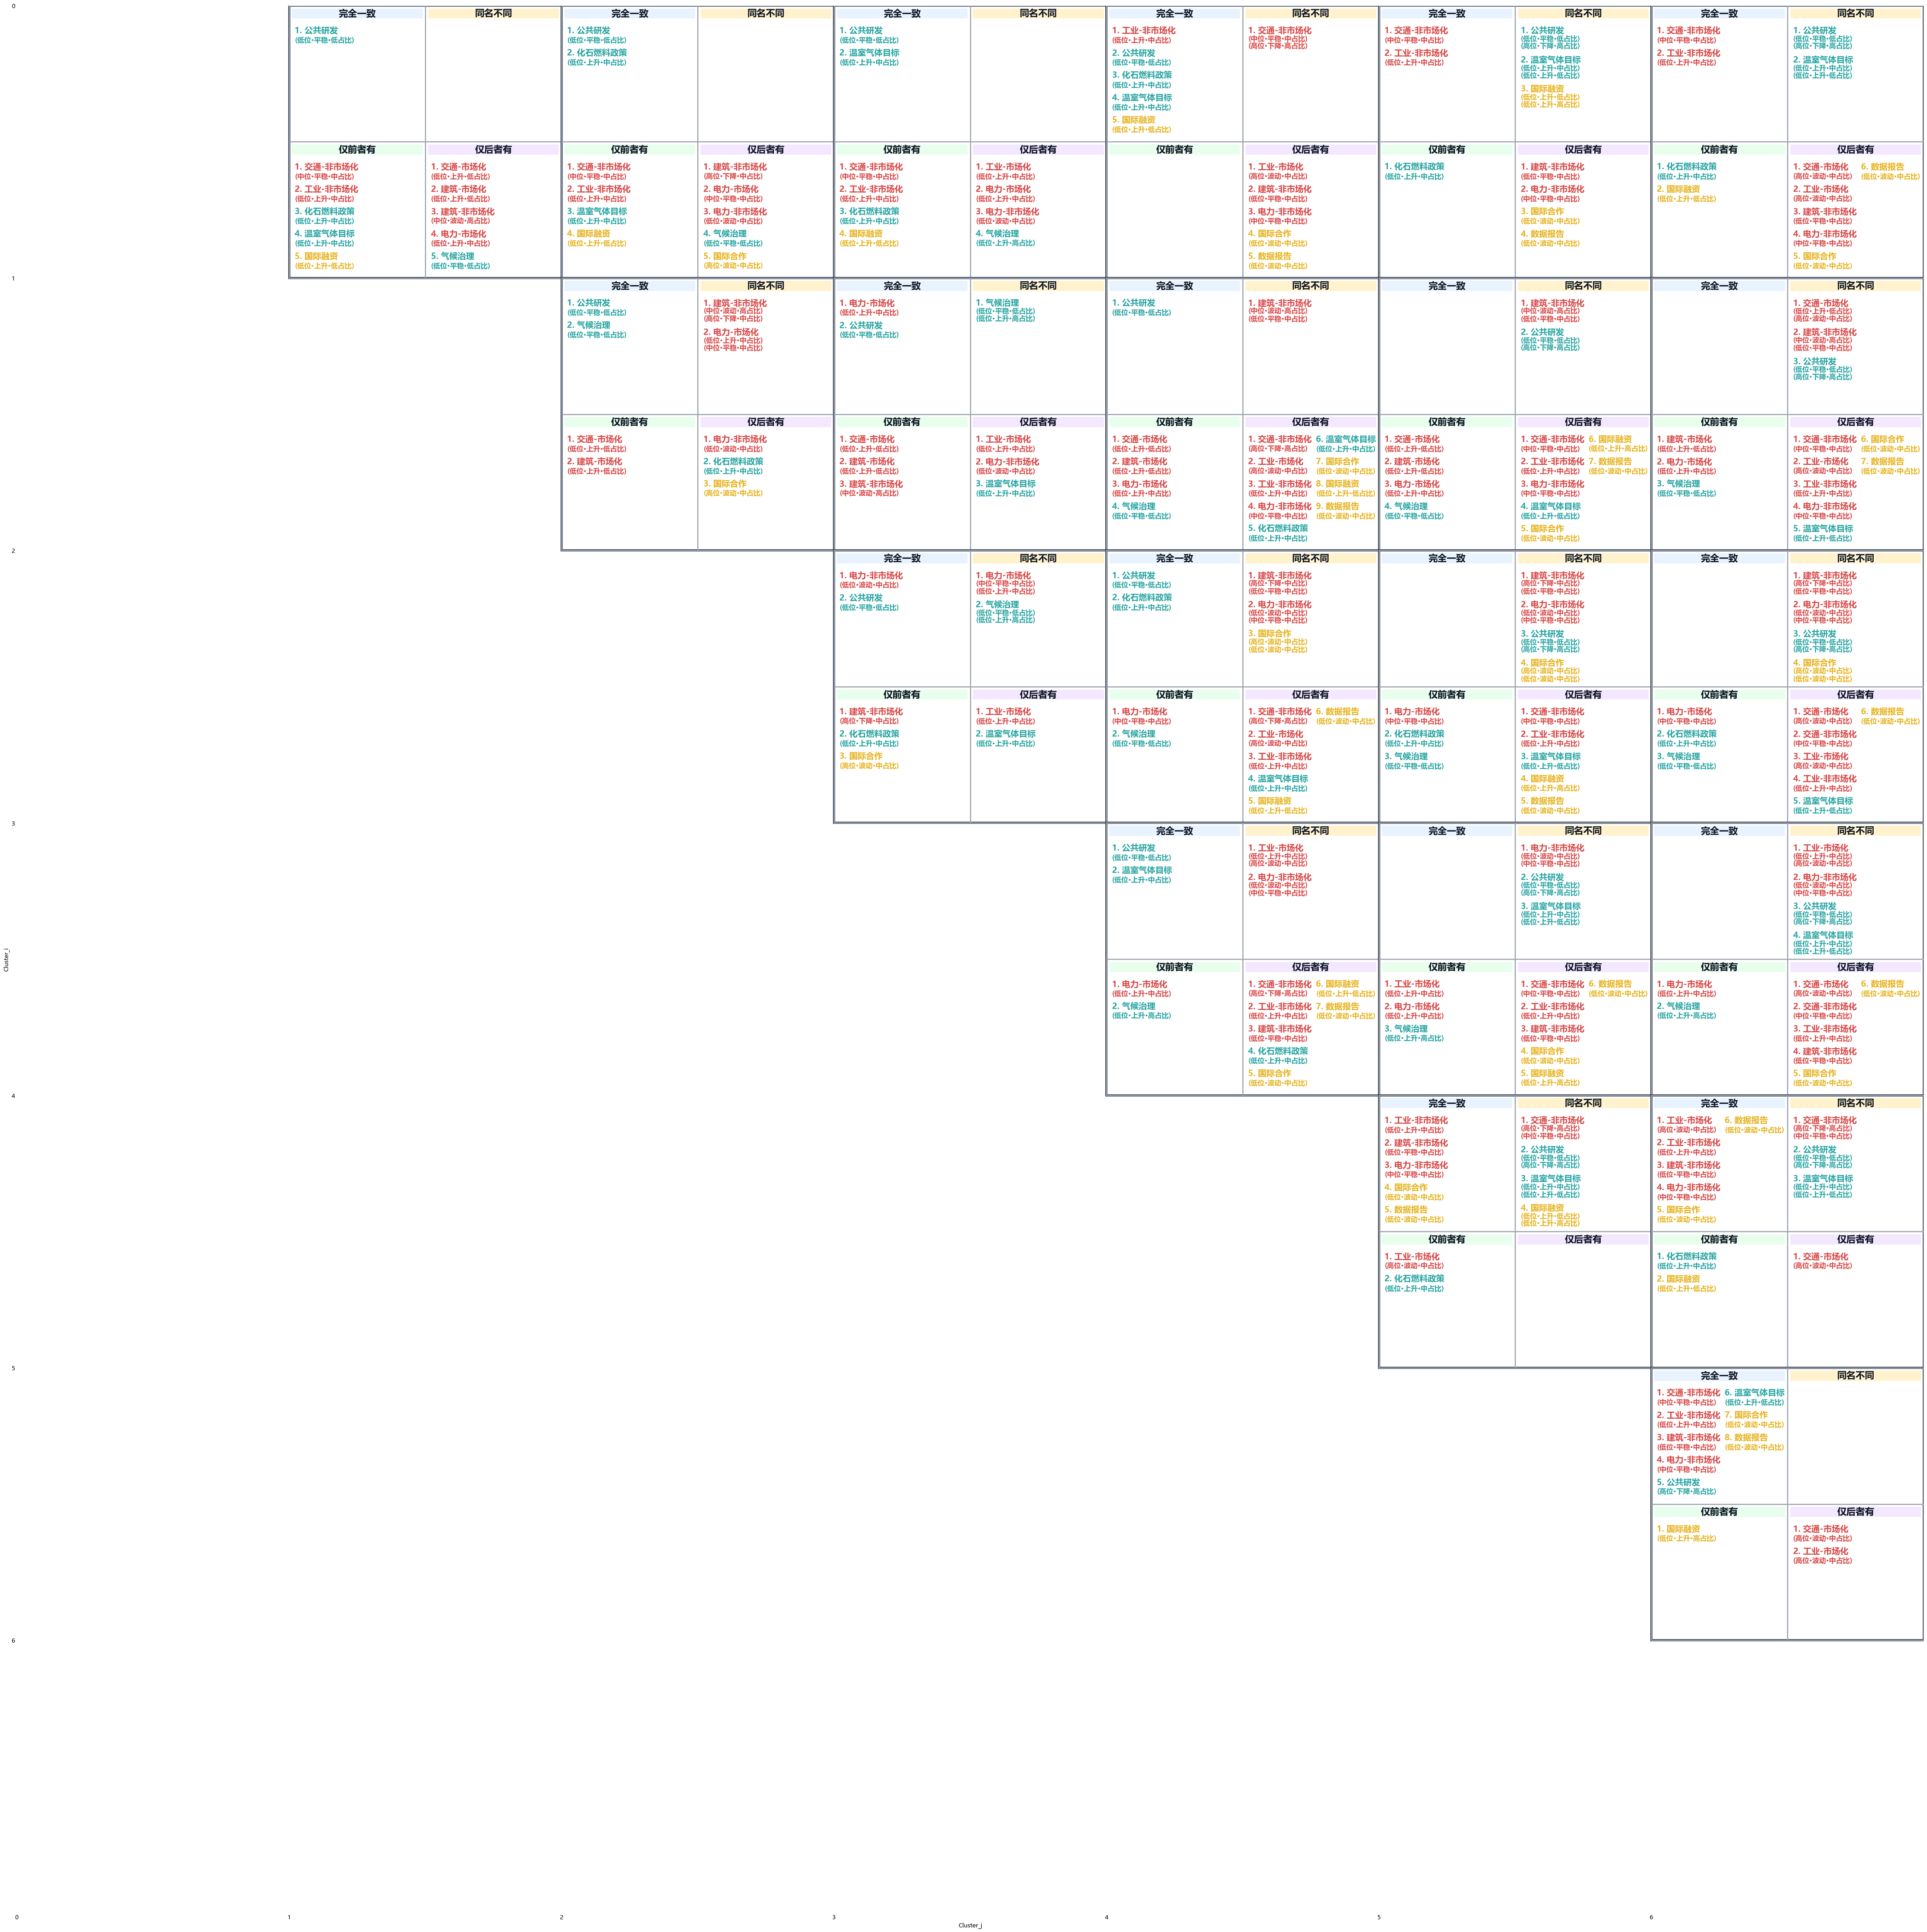

In [69]:
# -*- coding: utf-8 -*-  
"""
上三角矩阵（四象限）文字图（字体颜色按 L1 映射；列间距更安全；特征更紧凑）：
- 2 列 × 5 行；编号连续
- “政策名 ↔ 特征”间距单独控制；
- “同名不同”象限拥有独立的行距与“政策之间”间距参数（真正生效）
"""

import os, json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import textwrap

# ========= 路径 =========
DETAIL_PATH = r"F:\Desktop\CAMPF_Supplementary\code\K7_cluster_pairwise_detail_plus.csv"
CONFIG_PATH_WIN = r"F:\Desktop\CAMPF_Supplementary\data\config_mappings.json"
CONFIG_PATH_UPL = r"/mnt/data/config_mappings.json"
CONFIG_PATH = CONFIG_PATH_WIN if os.path.exists(CONFIG_PATH_WIN) else CONFIG_PATH_UPL

OUT_PATH = r"F:\Desktop\CAMPF_Supplementary\code\K7_text_matrix_L1fontcolor_dense.png"

# ========= 读取 =========
df = pd.read_csv(DETAIL_PATH, encoding_errors="ignore")
clusters = sorted(set(df["cluster_1"]).union(set(df["cluster_2"])))
n = len(clusters)

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = json.load(f)

# ========= L1 颜色 =========
L1_COLOR = {
    "LEV1_SEC":       "#D94C4C",
    "LEV1_CROSS_SEC": "#2CA6A4",
    "LEV1_INT":       "#E6B422",
}
FALLBACK_COLOR = "#111827"

l2_code_to_cn = cfg.get("level2_names", {})
l2_cn_to_code = {cn: code for code, cn in l2_code_to_cn.items()}

l2_to_l1, l3_to_l1 = {}, {}
for l3, v in cfg.get("level_mapping", {}).items():
    l3_to_l1[l3] = v.get("L1")
    if v.get("L2") and v.get("L1"):
        l2_to_l1[v["L2"]] = v["L1"]

def infer_l1_from_name(policy_name: str):
    if not policy_name:
        return None
    name = str(policy_name).strip()
    if "LEV3_" in name:
        for l3 in l3_to_l1.keys():
            if l3 in name:
                return l3_to_l1.get(l3)
    if name in l2_cn_to_code:
        return l2_to_l1.get(l2_cn_to_code[name])
    for cn, l2 in l2_cn_to_code.items():
        if cn and cn in name:
            return l2_to_l1.get(l2)
    return None

def font_color_for_policy(policy_name: str):
    return L1_COLOR.get(infer_l1_from_name(policy_name), FALLBACK_COLOR)

# ========= 全局样式 =========
plt.rcParams['font.family'] = ['Microsoft YaHei', 'SimHei', 'Noto Sans CJK SC', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ======== 版式参数 ========
CELL_SIZE_INCH   = 7.6
OUTER_FRAME_LW   = 4.4
QUAD_FRAME_LW    = 2.2

# 小标题条
TITLE_BAR_H_REL  = 0.115
TITLE_BAR_VPAD   = 0.010
TITLE_BAR_HPAD   = 0.010

# 字体
TITLE_FS         = 19.0
NAME_FS          = 17.0
ATTR_FS          = 14.0
ATTR_WEIGHT      = 'bold'

# 行距 & 间距参数
LINE_STEP_REL       = 0.034     # 全局行距（除“同名不同”外的象限）
LINE_STEP_REL_DIFF  = 0.024   # ★“同名不同”象限内部行距（单条内部各行之间）
NAME_ATTR_GAP_REL   = 0.040     # 政策名 ↔ 特征间距（所有象限一致）
DIFF_BLOCK_GAP_REL  = 0.0555      # “同名不同”块间距（两块特征之间）

# 政策之间的额外间距（同一象限内，一条政策整体与下一条政策整体之间）
POLICY_GAP_REL        = -0.01   # 全局（非“同名不同”）政策间距
POLICY_GAP_REL_DIFF   = 0.25   # ★“同名不同”专用政策间距（真正生效）

# 槽位
COLS_PER_QUAD    = 2
ROWS_PER_COL     = 5
COL_GUTTER_REL   = 0.030

# 小标题色
TITLE_FILL = {
    "完全一致": "#E8F3FF",
    "同名不同": "#FFF2CC",
    "仅前者有": "#E8FFED",
    "仅后者有": "#F3E8FF",
}

# 画布
fig_w = 1.4 + n * CELL_SIZE_INCH
fig_h = 1.6 + n * CELL_SIZE_INCH
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.set_xlim(0, n); ax.set_ylim(0, n)
ax.invert_yaxis(); ax.set_aspect('equal')
ax.set_xticks(range(n)); ax.set_xticklabels([str(c) for c in clusters], fontsize=12)
ax.set_yticks(range(n)); ax.set_yticklabels([str(c) for c in clusters], fontsize=12)
for s in ax.spines.values(): s.set_visible(False)
ax.tick_params(length=0)

# ========= 文本工具 =========
def parse_items(s: str):
    if pd.isna(s) or not str(s).strip():
        return []
    parts = [p for p in str(s).split(';') if p.strip()]
    out = []
    for p in parts:
        if '|' in p:
            name, attrs = p.split('|', 1)
            out.append((name.strip(), attrs.strip()))
        else:
            out.append((p.strip(), ""))
    return out

def to_bold_middle_dot(text: str) -> str:
    if not text: return text
    txt = text.replace(' + ', '+').replace(' +', '+').replace('+ ', '+')
    return txt.replace('+', '·')

def attrs_lines(attrs: str, width_chars: int, force_two_blocks: bool):
    if not attrs:
        return []
    blocks = [a.strip() for a in attrs.split('、')] if (force_two_blocks and '、' in attrs) else [attrs]
    lines = []
    for idx, part in enumerate(blocks):
        txt = f"({part})"
        txt = to_bold_middle_dot(txt)
        wrapped = textwrap.wrap(txt, width=max(10, width_chars - 2)) or [txt]
        lines.extend(wrapped)
        if force_two_blocks and idx < len(blocks)-1:
            lines.append("<BLOCK_GAP>")
    return lines

def wrap_name(num: int, name: str, width_chars: int):
    return textwrap.wrap(f"{num}. {name}", width=width_chars) or [f"{num}. {name}"]

# ========= 绘制 =========
def draw_quad(x, y, w, h, title, items, force_two_blocks=False):
    # 小标题
    t_x = x + TITLE_BAR_HPAD; t_w = w - 2 * TITLE_BAR_HPAD
    t_y = y + TITLE_BAR_VPAD; t_h = TITLE_BAR_H_REL * h - 2 * TITLE_BAR_VPAD
    ax.add_patch(Rectangle((t_x, t_y), t_w, t_h, facecolor=TITLE_FILL[title], lw=0))
    ax.text(t_x + t_w/2, t_y + t_h/2, title, fontsize=TITLE_FS, fontweight='bold',
            ha='center', va='center', color="#111827")

    # 内容区
    c_pad = 0.016
    c_x = x + c_pad; c_y = y + TITLE_BAR_H_REL * h + c_pad
    c_w = w - 2 * c_pad; c_h = h - TITLE_BAR_H_REL * h - 2 * c_pad

    # 两列 + gutter
    effective_w = c_w - COL_GUTTER_REL
    col_w  = effective_w / COLS_PER_QUAD

    # —— 行距/政策间距按象限选择
    line_step_abs  = (LINE_STEP_REL_DIFF if title == "同名不同" else LINE_STEP_REL) * h
    policy_gap_abs = (POLICY_GAP_REL_DIFF if title == "同名不同" else POLICY_GAP_REL) * h

    # —— 槽位高度：同名不同需要从总高度里预留 (ROWS_PER_COL-1)*policy_gap_abs 做“政策间距”
    if title == "同名不同":
        slot_h = (c_h - (ROWS_PER_COL - 1) * policy_gap_abs) / ROWS_PER_COL
    else:
        slot_h = c_h / ROWS_PER_COL

    est_chars = max(10, min(30, int(30 * (col_w / 0.5))))

    max_items = COLS_PER_QUAD * ROWS_PER_COL
    overflow  = max(0, len(items) - max_items)
    render_items = list(items[:max_items])
    if overflow > 0:
        render_items[-1] = (f"其余 {overflow} 条", "请放大画布或增加列/行")

    for k, (name, attrs) in enumerate(render_items):
        display_num = k + 1
        col_idx = 0 if k < ROWS_PER_COL else 1
        row_idx = k if k < ROWS_PER_COL else k - ROWS_PER_COL

        # 列起点（右列整体右移一个 gutter）
        sx = c_x + (col_idx * (col_w + (COL_GUTTER_REL if col_idx == 1 else 0)))
        # 行起点：同名不同需要叠加 row_idx 个 policy_gap_abs（把行与行之间拉开）
        sy = c_y + row_idx * slot_h
        if title == "同名不同":
            sy += row_idx * policy_gap_abs

        spx = sx + 0.004; spy = sy + 0.002

        fcolor = font_color_for_policy(name)
        name_lines = wrap_name(display_num, name, est_chars)
        attr_lines = attrs_lines(attrs, est_chars, force_two_blocks)

        cy = spy
        # 名称行
        for line in name_lines:
            ax.text(spx, cy, line, fontsize=NAME_FS, fontweight='bold',
                    ha='left', va='top', color=fcolor, clip_on=True)
            cy += line_step_abs

        # 名 ↔ 特征 间距（独立）
        cy += NAME_ATTR_GAP_REL * h

        # 特征行（带块间距占位）
        for idx, line in enumerate(attr_lines):
            if line == "<BLOCK_GAP>":
                cy += DIFF_BLOCK_GAP_REL * h
                continue
            ax.text(spx, cy, line, fontsize=ATTR_FS, fontweight=ATTR_WEIGHT,
                    ha='left', va='top', color=fcolor, clip_on=True)
            next_is_block_gap = (idx + 1 < len(attr_lines) and attr_lines[idx + 1] == "<BLOCK_GAP>")
            is_last_line = (idx == len(attr_lines) - 1)
            if not next_is_block_gap and not is_last_line:
                cy += line_step_abs

        # —— 循环末尾：非“同名不同”才在同槽位内继续加 policy_gap_abs
        #    “同名不同”已经通过 slot_h/起点 sy 的方式实现行与行之间的政策间距
        if title != "同名不同":
            cy += policy_gap_abs

def draw_cell(i, j, row):
    x, y = j, i
    # 外框
    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, lw=OUTER_FRAME_LW, ec="#374151"))
    # 四象限
    ax.add_patch(Rectangle((x, y),       0.5, 0.5, fill=False, lw=QUAD_FRAME_LW, ec="#9CA3AF"))
    ax.add_patch(Rectangle((x+0.5, y),   0.5, 0.5, fill=False, lw=QUAD_FRAME_LW, ec="#9CA3AF"))
    ax.add_patch(Rectangle((x, y+0.5),   0.5, 0.5, fill=False, lw=QUAD_FRAME_LW, ec="#9CA3AF"))
    ax.add_patch(Rectangle((x+0.5, y+0.5),0.5, 0.5, fill=False, lw=QUAD_FRAME_LW, ec="#9CA3AF"))

    eq_items    = parse_items(row.get("完全一致(名|起始+趋势+末端)", ""))
    diff_items  = parse_items(row.get("名称相同但聚类不同(名|簇1属性、簇2属性)", ""))
    only1_items = parse_items(row.get("仅前者有(名|起始+趋势+末端)", ""))
    only2_items = parse_items(row.get("仅后者有(名|起始+趋势+末端)", ""))

    quads = [
        (x,     y,     0.5, 0.5, "完全一致", eq_items,   False),
        (x+0.5, y,     0.5, 0.5, "同名不同", diff_items, True),   # 同名不同：force_two_blocks=True
        (x,     y+0.5, 0.5, 0.5, "仅前者有", only1_items,False),
        (x+0.5, y+0.5, 0.5, 0.5, "仅后者有", only2_items,False),
    ]
    for qx, qy, qw, qh, title, items, force_two in quads:
        draw_quad(qx, qy, qw, qh, title, items, force_two_blocks=force_two)

# ========= 渲染上三角 =========
pair_map = {(int(r["cluster_1"]), int(r["cluster_2"])): r for _, r in df.iterrows()}
for i, ci in enumerate(clusters):
    for j, cj in enumerate(clusters):
        if i < j:
            row = pair_map.get((ci, cj), {})
            draw_cell(i, j, row)

# 轴
ax.set_xlabel("Cluster_j", fontsize=12)
ax.set_ylabel("Cluster_i", fontsize=12)

plt.tight_layout()
#plt.savefig(OUT_PATH, dpi=420, bbox_inches='tight', facecolor='white')
print(f"✅ 输出图片：{OUT_PATH}")
